PySpark and ML libraries imported successfully.
Spark Session created.
Successfully loaded file: U-2015-DCF-Block_1D-Teaching_Staff_Summary-2015.csv

Schema of the loaded data:
root
 |-- institution_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- survey_year: integer (nullable = true)
 |-- designation: string (nullable = true)
 |-- sanctioned_strength: integer (nullable = true)
 |-- in_position_direct: integer (nullable = true)
 |-- in_position_cas: integer (nullable = true)
 |-- no_of_phd_teachers: integer (nullable = true)


Data after cleaning and adding columns (first 5 rows):
+--------------+--------------------+-----------+--------------------+-------------------+------------------+---------------+------------------+-----------------+-------+
|institution_id|                name|survey_year|         designation|sanctioned_strength|in_position_direct|in_position_cas|no_of_phd_teachers|total_in_position|vacancy|
+--------------+--------------------+----------

C:\Users\gchir\AppData\Local\Temp\ipykernel_6824\2767295588.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


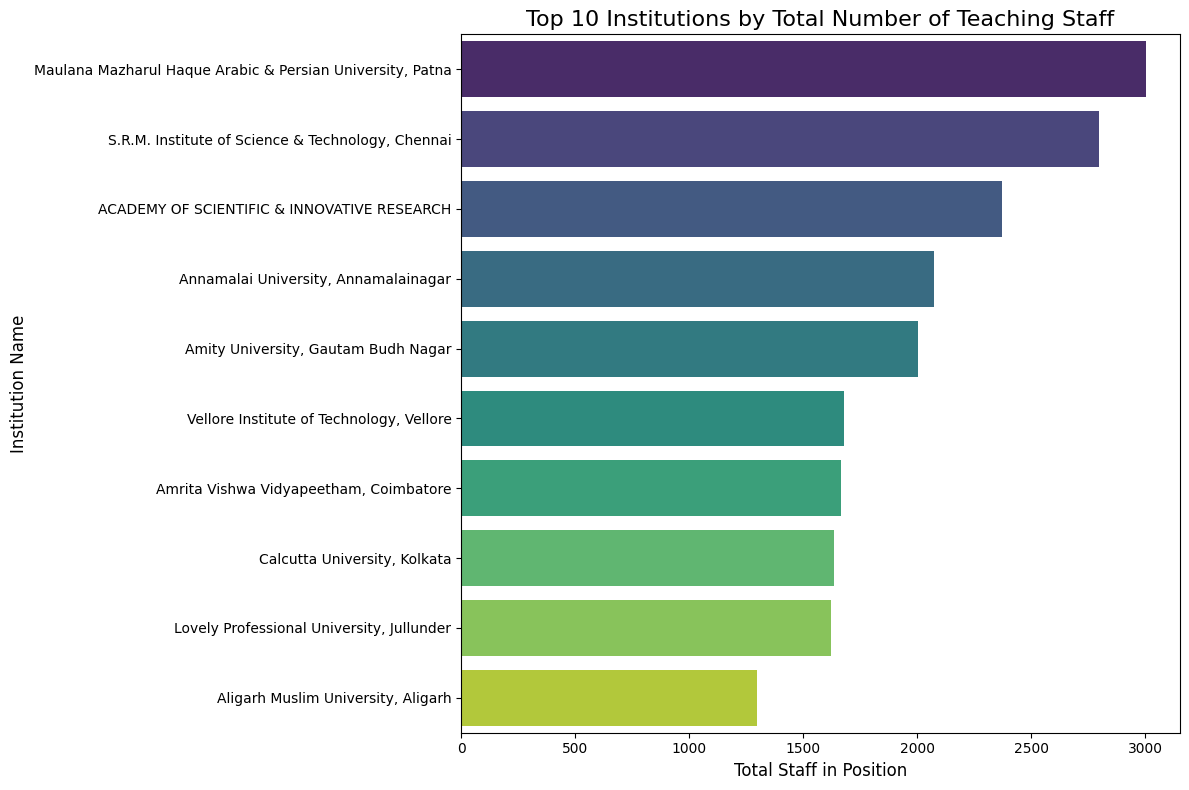


Aggregating for Plot 2: Staff by Designation (Bar Graph)...


C:\Users\gchir\AppData\Local\Temp\ipykernel_6824\2767295588.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


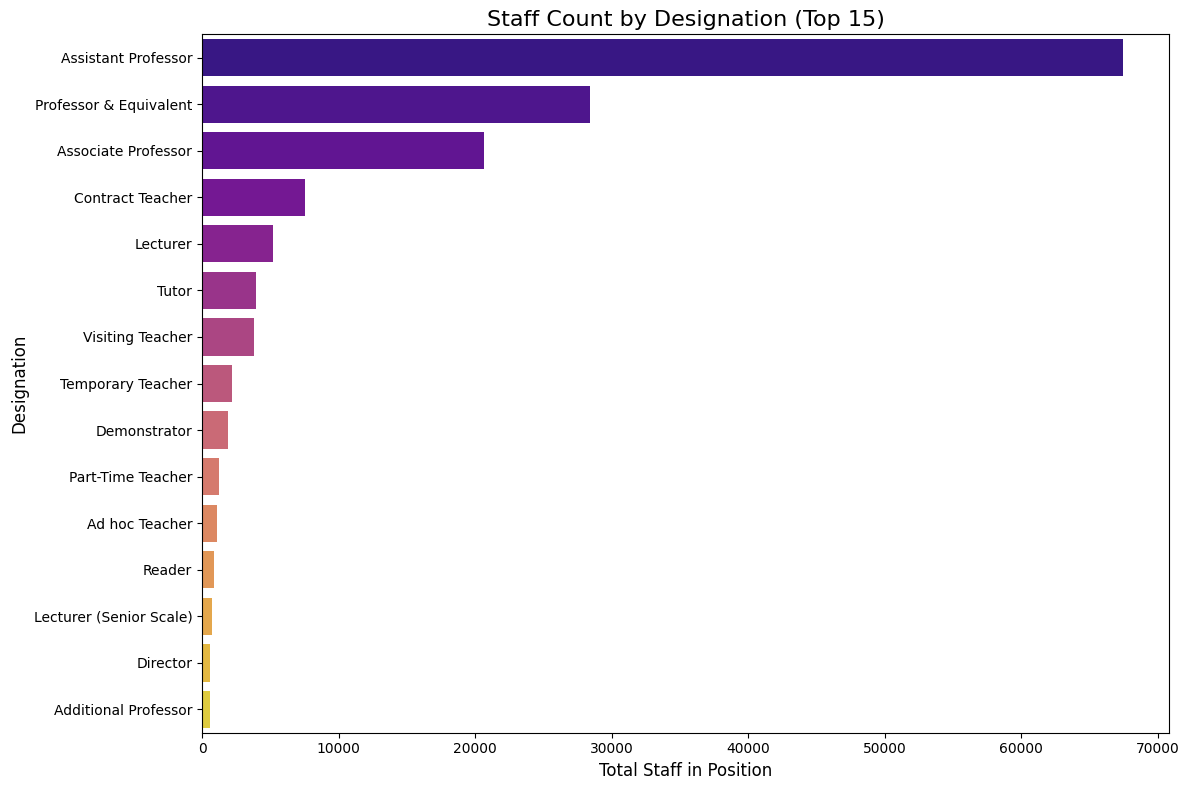


Aggregating for Plot 3: Staff in Position (Histogram)...


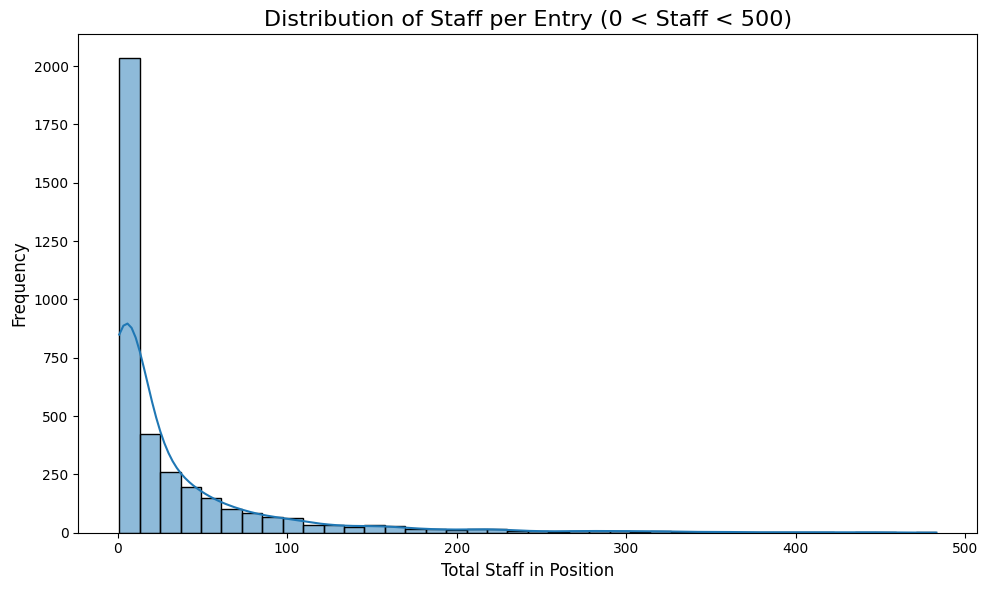


Aggregating for Plot 4: Correlation Matrix (Heat Map)...


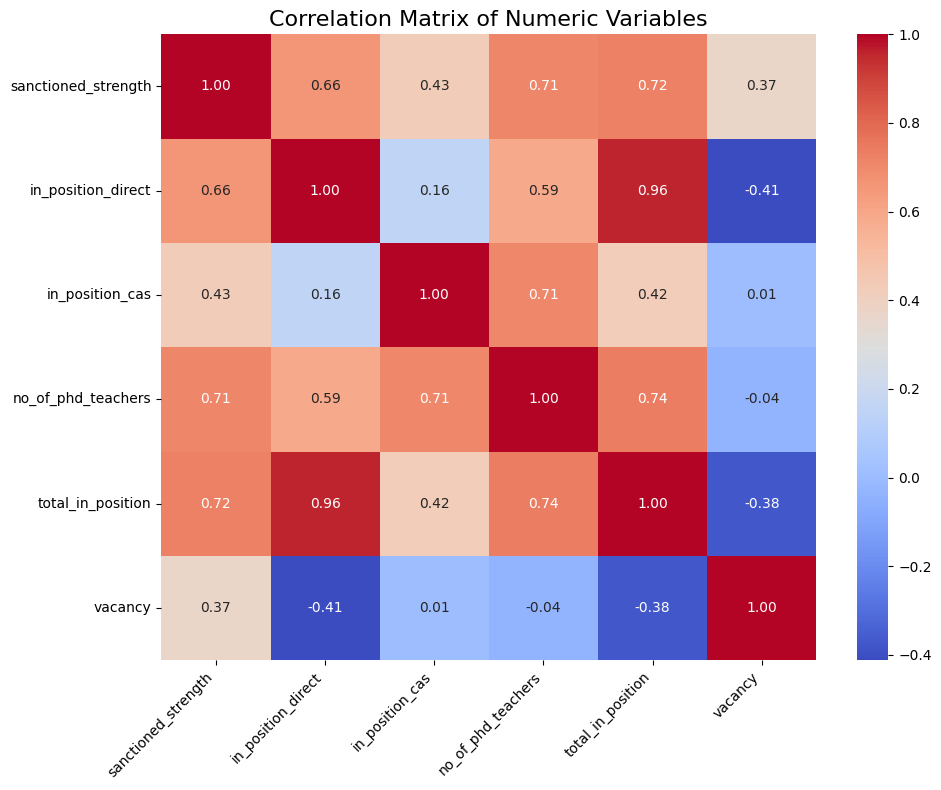


Aggregating for Plot 5: Staff Distribution (Pie Chart)...


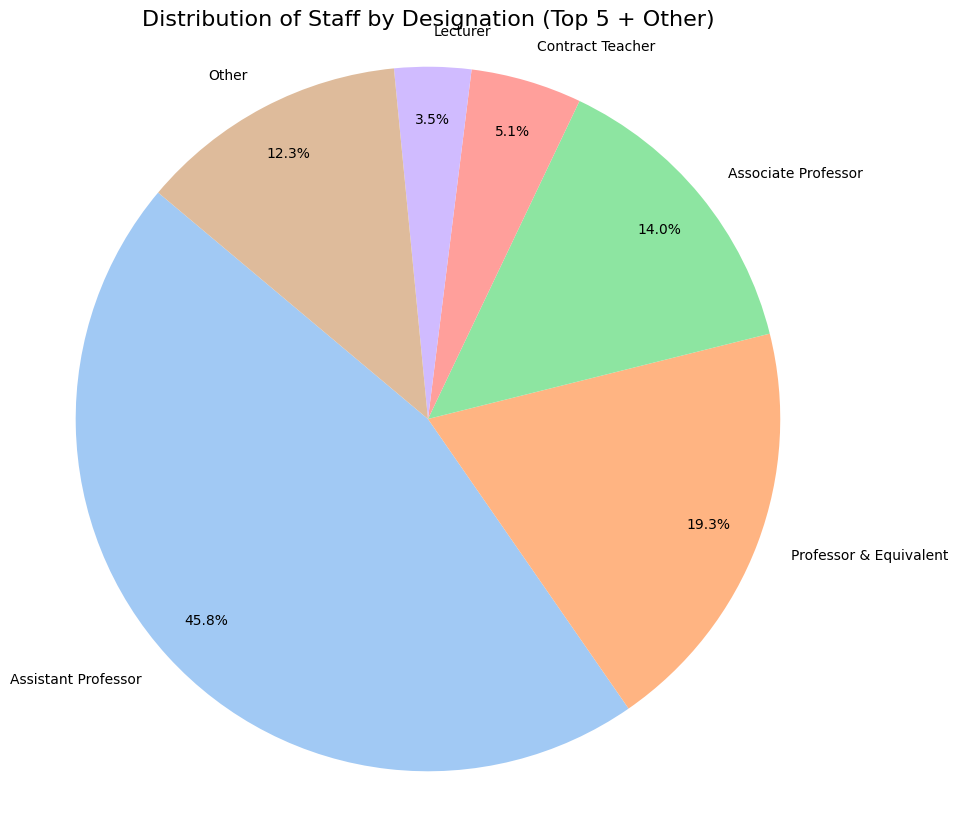


Stopping Spark Session.


In [21]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import PySpark and ML libraries
try:
    from pyspark.sql import SparkSession
    from pyspark.sql import functions as F
    from pyspark.sql.types import FloatType
    from pyspark.ml.stat import Correlation
    from pyspark.ml.feature import VectorAssembler
    print("PySpark and ML libraries imported successfully.")
except ImportError:
    print("---")
    print("ERROR: PySpark is not installed or ML libraries are missing.")
    print("Please install it first, e.g.: !pip install pyspark")
    print("---")
    # Stop execution if PySpark isn't available
    raise

def main():
    # 1. Initialize Spark Session
    spark = SparkSession.builder \
        .appName("TeachingStaffAnalysis") \
        .getOrCreate()
    
    print("Spark Session created.")

    # 2. Load the Data
    
    # Correct file name
    file_path = "U-2015-DCF-Block_1D-Teaching_Staff_Summary-2015.csv"
    
    # Read the CSV. Using 'nullValue' to handle 'NA' strings.
    try:
        df = spark.read.csv(file_path, header=True, inferSchema=True, nullValue="NA")
        print(f"Successfully loaded file: {file_path}")
    except Exception as e:
        print(f"--- ERROR LOADING FILE ---")
        print(f"Spark could not find or read the file: {file_path}")
        print("Please make sure the file is in the exact same directory as your .ipynb notebook.")
        print(f"Full error: {e}")
        spark.stop()
        return

    print("\nSchema of the loaded data:")
    df.printSchema()

    # 3. Clean the Data
    
    # Cast numeric columns to Float for consistency
    numeric_cols = [
        'sanctioned_strength',
        'in_position_direct',
        'in_position_cas',
        'no_of_phd_teachers'
    ]
    
    for col_name in numeric_cols:
         if col_name in df.columns:
            df = df.withColumn(col_name, F.col(col_name).cast(FloatType()))
    
    # Filter out 'ALL' rows (subtotals)
    df_cleaned = df.filter(F.col("designation") != "ALL")

    # Fill nulls in position columns with 0
    df_cleaned = df_cleaned.fillna(0, subset=['in_position_direct', 'in_position_cas'])

    # 4. Add Two New Columns
    
    # Add 'total_in_position'
    df_cleaned = df_cleaned.withColumn(
        'total_in_position',
        F.col('in_position_direct') + F.col('in_position_cas')
    )

    # Add 'vacancy'
    df_cleaned = df_cleaned.withColumn(
        'vacancy',
        F.col('sanctioned_strength') - F.col('total_in_position')
    )

    print("\nData after cleaning and adding columns (first 5 rows):")
    df_cleaned.show(5)

    # --- 5. Generate Plots ---

    # --- Plot 1: Bar Graph - Top 10 Institutions ---
    print("\nAggregating for Plot 1: Top 10 Institutions (Bar Graph)...")
    top_10_institutions_spark = df_cleaned.groupBy("name") \
        .agg(F.sum("total_in_position").alias("total_staff")) \
        .orderBy(F.col("total_staff").desc()) \
        .limit(10)

    top_10_institutions_pd = top_10_institutions_spark.toPandas()

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='total_staff',
        y='name',
        data=top_10_institutions_pd,
        palette="viridis"
    )
    plt.title('Top 10 Institutions by Total Number of Teaching Staff', fontsize=16)
    plt.xlabel('Total Staff in Position', fontsize=12)
    plt.ylabel('Institution Name', fontsize=12)
    plt.tight_layout()
    plt.savefig('spark_top_10_institutions.png')
    plt.show()


    # --- Plot 2: Bar Graph - Staff by Designation ---
    print("\nAggregating for Plot 2: Staff by Designation (Bar Graph)...")
    designation_dist_spark_bar = df_cleaned.groupBy("designation") \
        .agg(F.sum("total_in_position").alias("total_staff")) \
        .orderBy(F.col("total_staff").desc()) \
        .limit(15) # Limit to top 15 to keep it readable

    designation_dist_pd_bar = designation_dist_spark_bar.toPandas()

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='total_staff',
        y='designation',
        data=designation_dist_pd_bar,
        palette="plasma"
    )
    plt.title('Staff Count by Designation (Top 15)', fontsize=16)
    plt.xlabel('Total Staff in Position', fontsize=12)
    plt.ylabel('Designation', fontsize=12)
    plt.tight_layout()
    plt.savefig('spark_designation_barchart.png')
    plt.show()

    
    # --- Plot 3: Histogram - Distribution of Staff in Position ---
    print("\nAggregating for Plot 3: Staff in Position (Histogram)...")
    # Filter for more reasonable numbers to see a distribution
    histogram_pd = df_cleaned.select("total_in_position") \
        .filter("total_in_position > 0 AND total_in_position < 500") \
        .toPandas()

    plt.figure(figsize=(10, 6))
    sns.histplot(histogram_pd['total_in_position'], bins=40, kde=True)
    plt.title('Distribution of Staff per Entry (0 < Staff < 500)', fontsize=16)
    plt.xlabel('Total Staff in Position', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.savefig('spark_staff_histogram.png')
    plt.show()

    
    # --- Plot 4: Heat Map - Correlation Matrix ---
    print("\nAggregating for Plot 4: Correlation Matrix (Heat Map)...")
    
    corr_numeric_cols = [
        'sanctioned_strength',
        'in_position_direct',
        'in_position_cas',
        'no_of_phd_teachers',
        'total_in_position',
        'vacancy'
    ]
    
    # Drop rows with any nulls in these columns for correlation
    corr_df = df_cleaned.select(corr_numeric_cols).dropna()
    
    # Assemble columns into a single vector
    assembler = VectorAssembler(
        inputCols=corr_numeric_cols,
        outputCol="features"
    )
    corr_df_vector = assembler.transform(corr_df).select("features")

    # Calculate Pearson correlation matrix
    # Check if there is data left after dropping nulls
    if corr_df_vector.count() > 0:
        matrix = Correlation.corr(corr_df_vector, "features").head()
        corr_matrix = matrix[0].toArray()

        # Convert to Pandas DataFrame for plotting
        corr_pd = pd.DataFrame(
            corr_matrix,
            columns=corr_numeric_cols,
            index=corr_numeric_cols
        )

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            corr_pd,
            annot=True,       # Show numbers in cells
            cmap='coolwarm',  # Color scheme
            fmt=".2f"         # Format numbers to 2 decimal places
        )
        plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('spark_correlation_heatmap.png')
        plt.show()
    else:
        print("Could not generate correlation matrix: No non-null data pairs found.")

        
    # --- Plot 5: Pie Chart - Staff Distribution by Designation ---
    print("\nAggregating for Plot 5: Staff Distribution (Pie Chart)...")
    designation_dist_spark_pie = df_cleaned.groupBy("designation") \
        .agg(F.sum("total_in_position").alias("total_staff")) \
        .orderBy(F.col("total_staff").desc())

    # Convert to Pandas for plotting
    designation_dist_pd_pie = designation_dist_spark_pie.toPandas().set_index('designation')

    # Logic to group into Top 5 + 'Other'
    plot_data_pd_pie = designation_dist_pd_pie
    if len(designation_dist_pd_pie) > 5:
        top_5 = designation_dist_pd_pie.head(5)
        other_sum = designation_dist_pd_pie.iloc[5:]['total_staff'].sum()
        if other_sum > 0:
            # Use pd.Series to create the 'Other' row
            other_row = pd.Series({'total_staff': other_sum}, name='Other')
            # Convert the 'Other' Series to a DataFrame and concatenate
            other_df = other_row.to_frame().T
            top_5 = pd.concat([top_5, other_df])
        plot_data_pd_pie = top_5

    # Plot
    plt.figure(figsize=(10, 10))
    plt.pie(
        plot_data_pd_pie['total_staff'],
        labels=plot_data_pd_pie.index,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        colors=sns.color_palette('pastel')
    )
    plt.title('Distribution of Staff by Designation (Top 5 + Other)', fontsize=16)
    plt.axis('equal')
    plt.savefig('spark_staff_distribution_pie.png')
    plt.show()
    
    
    # 6. Stop Spark Session
    print("\nStopping Spark Session.")
    spark.stop()

# Run the main function
if __name__ == "__main__":
    main()